# Trabalho 2 CMP197 Fundamentos de Visão Computacional - *Content-based Image Retrieval* 

Alunos: Artur Martini e Renan Britz \
Professor: Dr. Cláudio Rosito Jung

*Enunciado: Content-based image retrieval (CBIR) consiste em fornecer uma imagem de consulta e recuperar imagens "semelhantes" em uma base de dados. O objetivo desse trabalho é criar um sistema de CBIR usando informação de forma como medida de similaridade. O sistema recebe como entrada uma imagem de busca, um número inteiro positivo N, e então retorna as N imagens da base de dados mais semelhantes à imagem de busca, em ordem descresente de similaridade.*

*Os testes serão feitos na base de imagens binárias The 216-Shape Database.*

---

Esse segundo trabalho de implementação foi dividido em 4 partes:

**Parte 1** - Pré-tratamento e análise visual dos dados \
**Parte 2** - Features "manuais" \
**Parte 3** - Structural Similarity Index (SSIM) \
**Parte 4** - Dense vector representation com CLIP model \

*Observação: Aplicar a rotina de transformação das imagens em todos os métodos avaliados. Variação aleatória da escala entre [0.85, 1.15] e da rotação da imagem de consulta e de busca.*

---

**TODO LIST:**

- [ ] parte 1: implementar
- [ ] parte 2: implementar
- [ ] parte 3: implementar
- [ ] parte 4: refinar

## Parte 1 - Pré-processamento das imagens 


In [122]:
import ipyplot 
from PIL import Image 
import glob


In [123]:
files = glob.glob('./data/pngs/*.png')

# get classes names from img paths
classes = ['bird', 'Bone', 'brick', 'camel', 'car', 'children', 'classic', 'elephant', 'face', 'fork', 'fountain', 'Glas', 'hammer', 'Heart', 'key', 'Misk', 'ray', 'turtle']

path_class_img = []

for file in files:
    for c in classes:
        if c in file:
            img_class = c 

    img = Image.open(file)

    data = {"path": file,
            "class": img_class,
            "img": img}
    
    path_class_img.append(data)


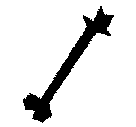
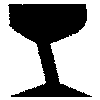
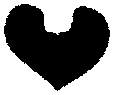
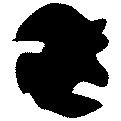
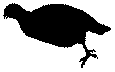
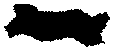
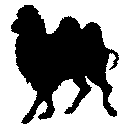
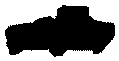
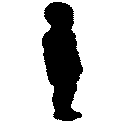
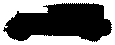
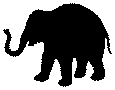
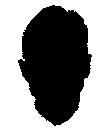
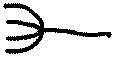
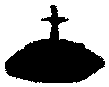
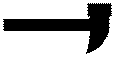
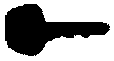
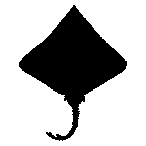
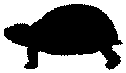


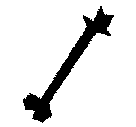
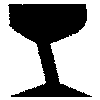
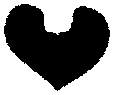
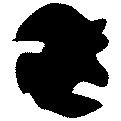
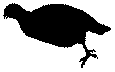
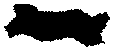
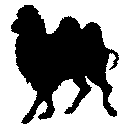
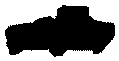
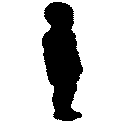
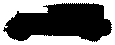
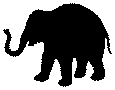
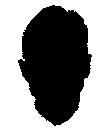
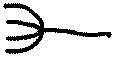
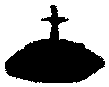
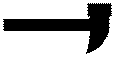
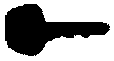
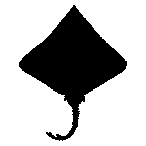
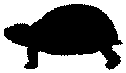

In [128]:
# plot one img per class
ipyplot.plot_class_representations(images=[im["img"] for im in path_class_img], labels=[im["class"] for im in path_class_img], img_width=160)


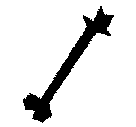
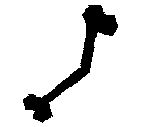
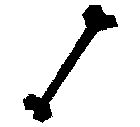
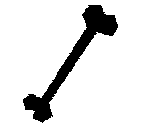
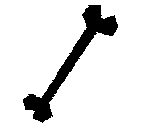
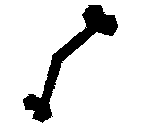
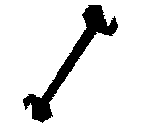
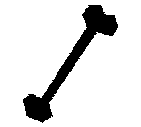
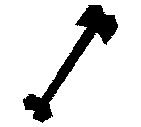
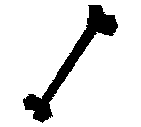
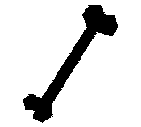
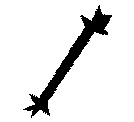
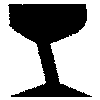
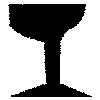
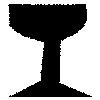
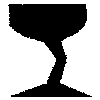
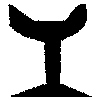
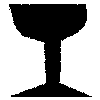
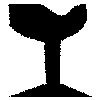
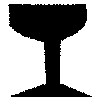
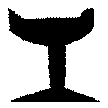
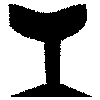
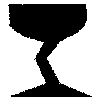
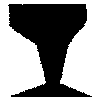
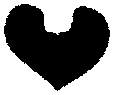
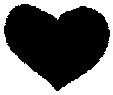
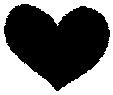
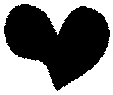
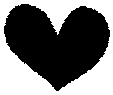
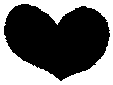
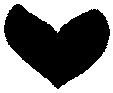
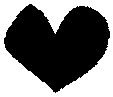
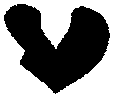
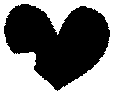
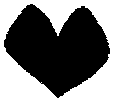
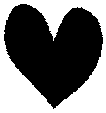
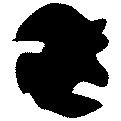
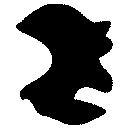
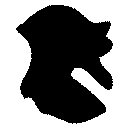
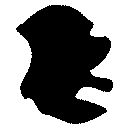
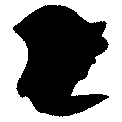
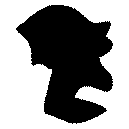
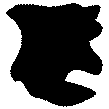
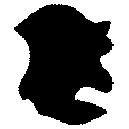
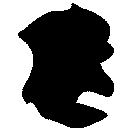
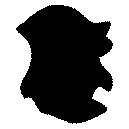
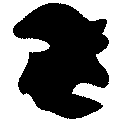
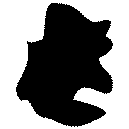
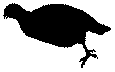
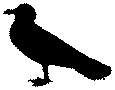
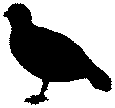
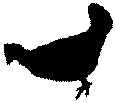
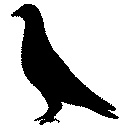
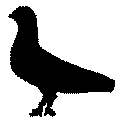
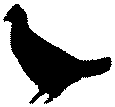
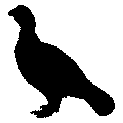
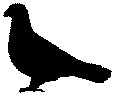
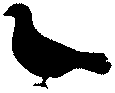
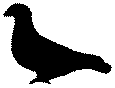
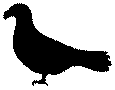
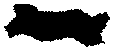
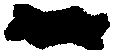
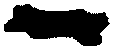
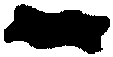
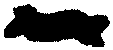
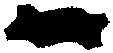
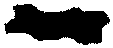
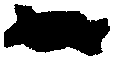
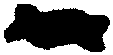
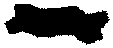
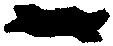
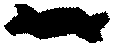
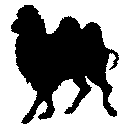
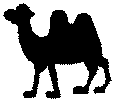
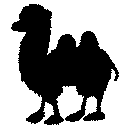
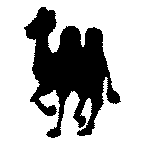
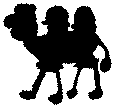
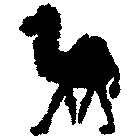
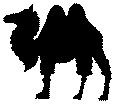
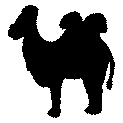
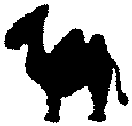
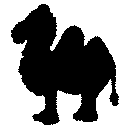
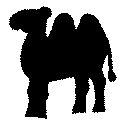
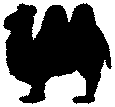
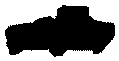
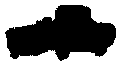
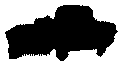
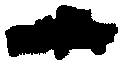
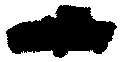
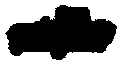
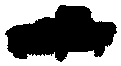
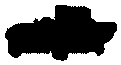
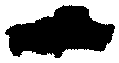
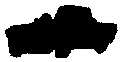
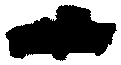
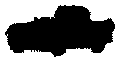
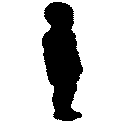
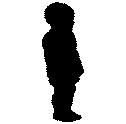
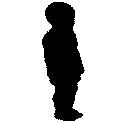
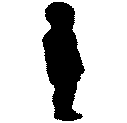
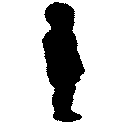
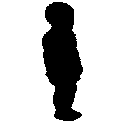
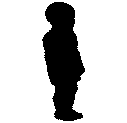
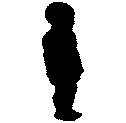
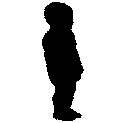
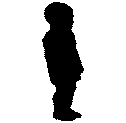
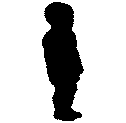
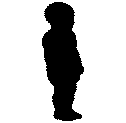
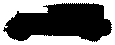
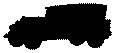
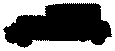
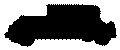
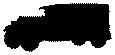
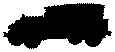
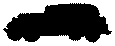
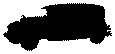
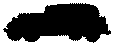
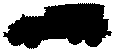
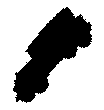
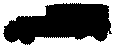
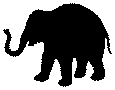
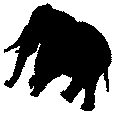
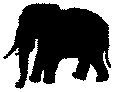
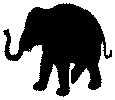
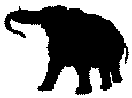
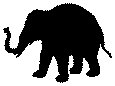
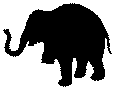
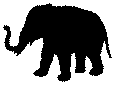
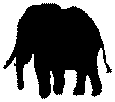
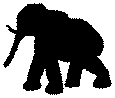
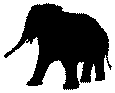
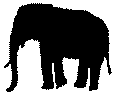
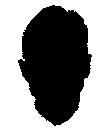
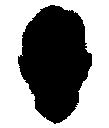
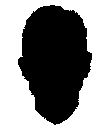
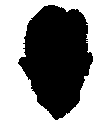
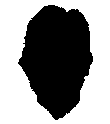
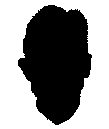
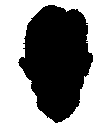
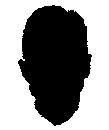
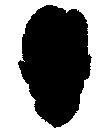
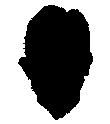
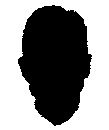
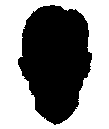
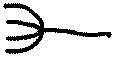
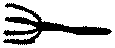
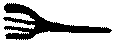
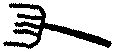
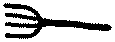
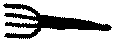
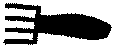
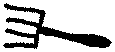
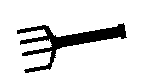
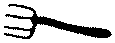
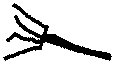
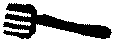
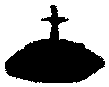
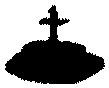
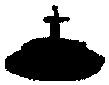
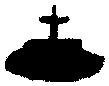
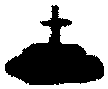
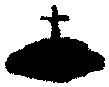
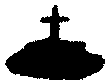
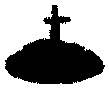
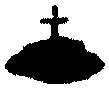
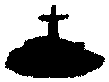
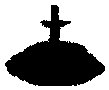
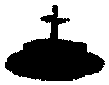
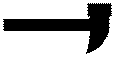
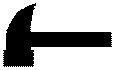
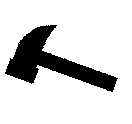
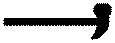
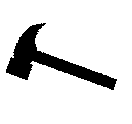
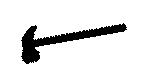
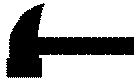
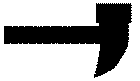
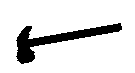
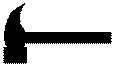
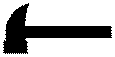
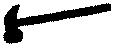
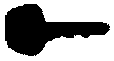
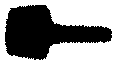
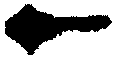
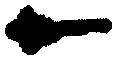
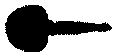
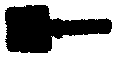
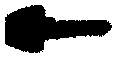
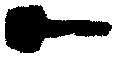
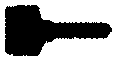
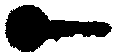
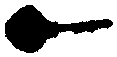
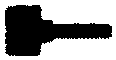
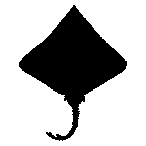
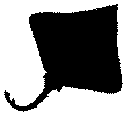
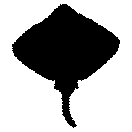
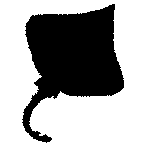
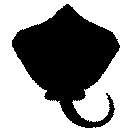
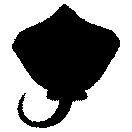
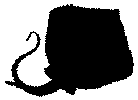
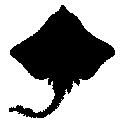
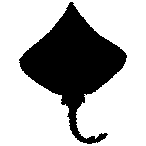
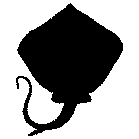
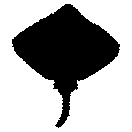
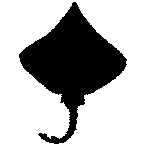
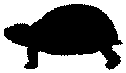
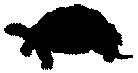
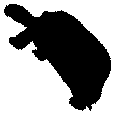
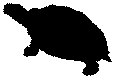
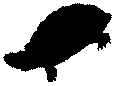
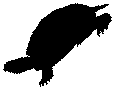
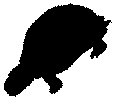
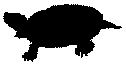
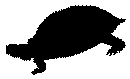
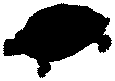
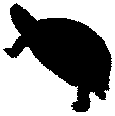
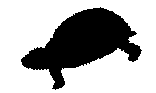


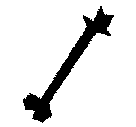
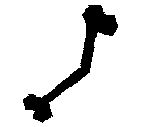
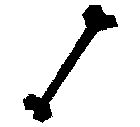
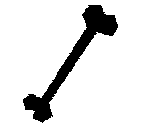
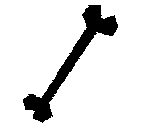
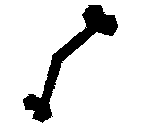
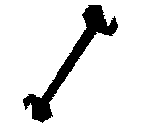
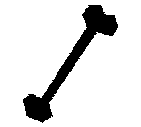
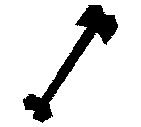
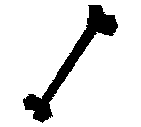
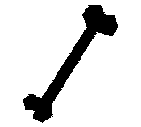
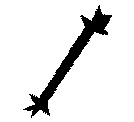
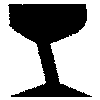
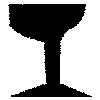
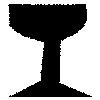
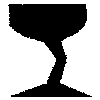
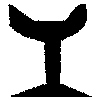
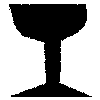
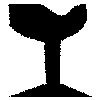
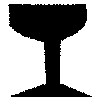
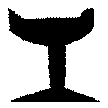
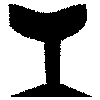
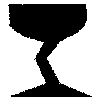
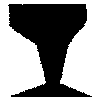
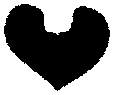
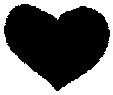
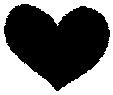
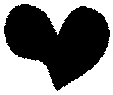
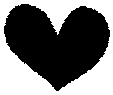
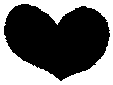
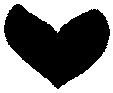
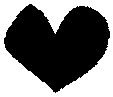
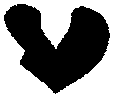
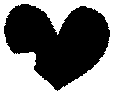
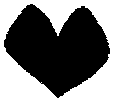
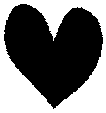
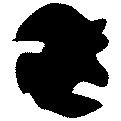
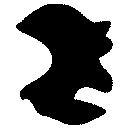
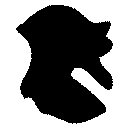
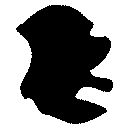
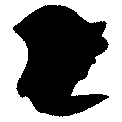
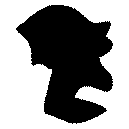
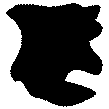
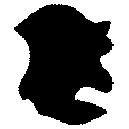
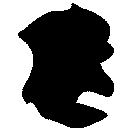
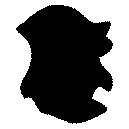
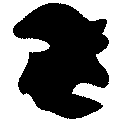
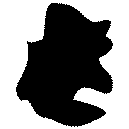
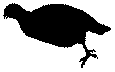
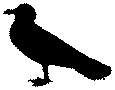
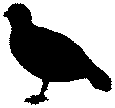
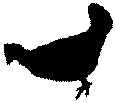
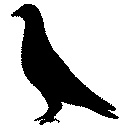
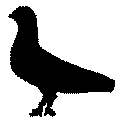
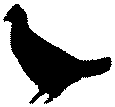
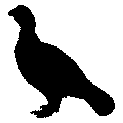
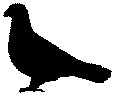
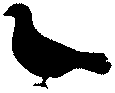
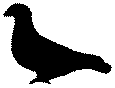
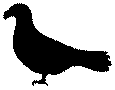
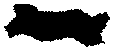
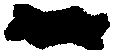
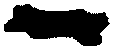
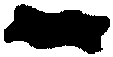
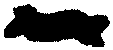
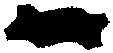
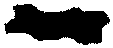
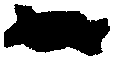
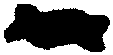
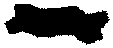
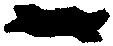
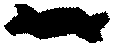
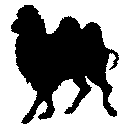
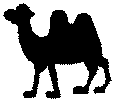
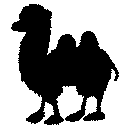
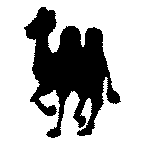
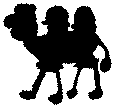
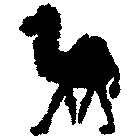
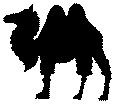
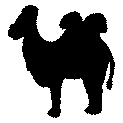
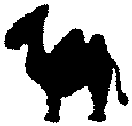
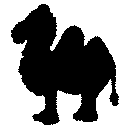
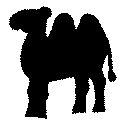
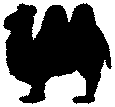
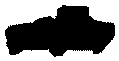
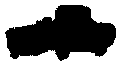
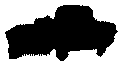
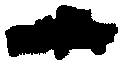
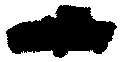
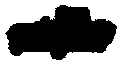
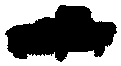
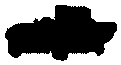
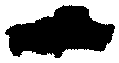
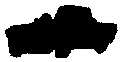
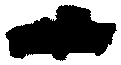
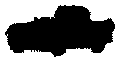
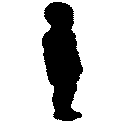
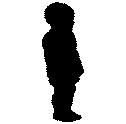
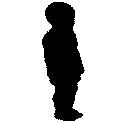
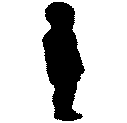
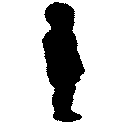
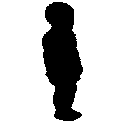
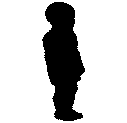
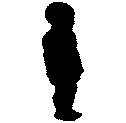
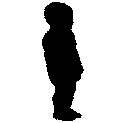
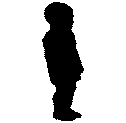
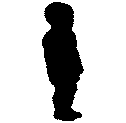
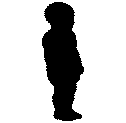
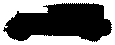
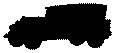
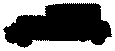
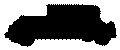
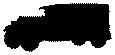
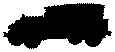
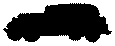
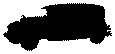
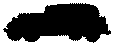
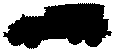
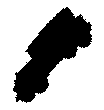
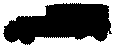
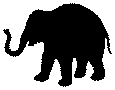
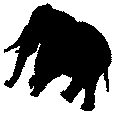
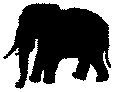
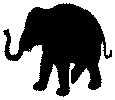
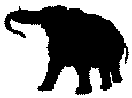
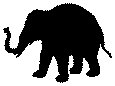
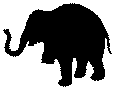
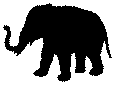
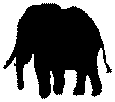
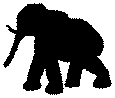
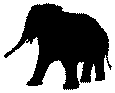
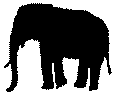
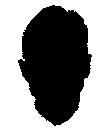
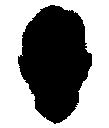
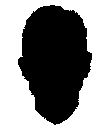
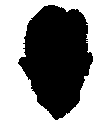
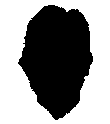
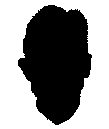
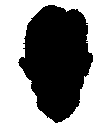
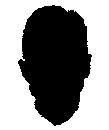
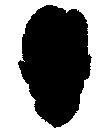
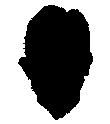
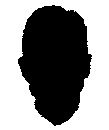
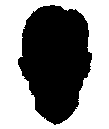
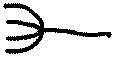
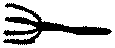
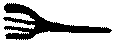
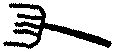
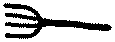
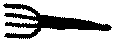
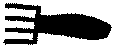
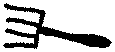
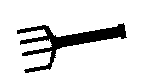
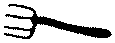
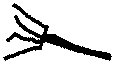
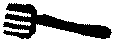
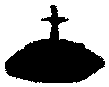
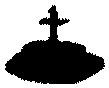
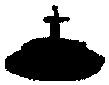
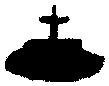
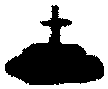
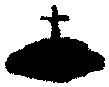
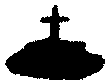
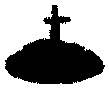
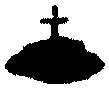
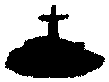
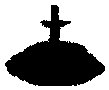
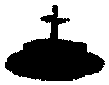
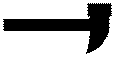
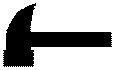
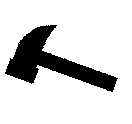
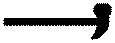
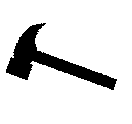
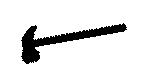
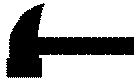
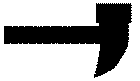
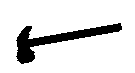
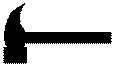
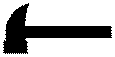
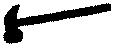
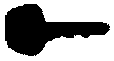
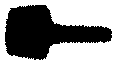
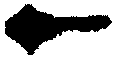
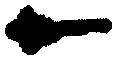
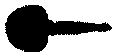
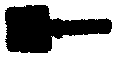
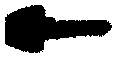
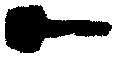
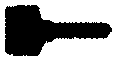
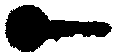
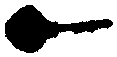
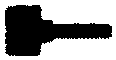
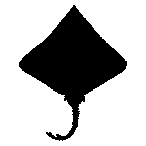
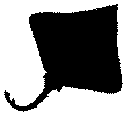
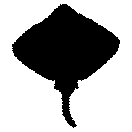
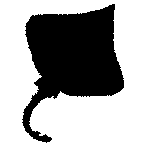
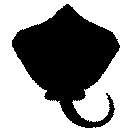
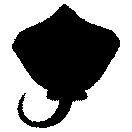
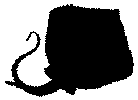
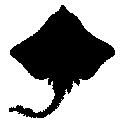
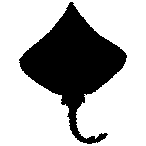
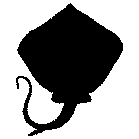
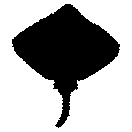
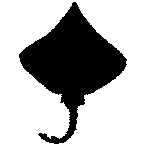
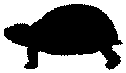
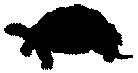
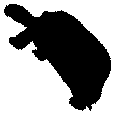
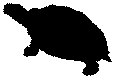
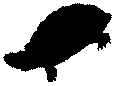
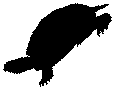
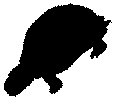
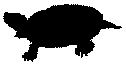
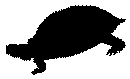
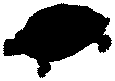
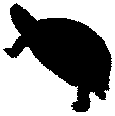
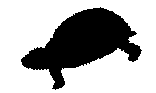

In [129]:
# plot all imgs by tabs
ipyplot.plot_class_tabs(images=[im["img"] for im in path_class_img], labels=[im["class"] for im in path_class_img], max_imgs_per_tab=20, img_width=100)

In [159]:
img_teste = path_class_img[:][1]["img"]

size = 128, 128

img_teste.thumbnail(size, Image.ANTIALIAS)

widths = []
heights = []

for i in range(len(path_class_img)):
    widths.append(path_class_img[:][i]["img"].size[0])
    heights.append(path_class_img[:][i]["img"].size[1])


In [168]:
import numpy as np

print(f'max width: {np.asarray(widths).max()}, max height: {np.asarray(heights).max()}')

blank_img = Image.new("L", (200, 200))


max width: 156, max height: 146


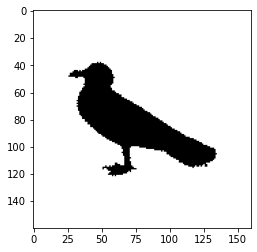

In [276]:
import cv2 as cv

height = 160
width = 160

cv_img = cv.imread(path_class_img[:][20]["path"])

def add_border_to_imgs(img, final_height, final_width):
    top = int((height - cv_img.shape[0]) / 2)
    bottom = top
    # adiciona uma linha superior e/ou esquerda se o valor de pixels é impar
    if cv_img.shape[0]%2 != 0:
        top += 1
    left = int((width - cv_img.shape[1]) / 2)
    right = left
    if cv_img.shape[1]%2 != 0:
        left += 1

    cv_img_with_border = cv.copyMakeBorder(cv_img, top, bottom, left, right, cv.BORDER_CONSTANT, None, value=(255, 255, 255))

    # print(f'top: {top}, bottom: {bottom}, left: {left}, right: {right}')
    # print(f'original: {cv_img.shape}, with borders: {cv_img_with_border.shape}')

    return cv_img_with_border

new_img = add_border_to_imgs(img=cv_img, final_height=height, final_width=width)

plt.imshow(new_img)
plt.show()

In [247]:
cp_path_class_img = path_class_img

for i in range(len(cp_path_class_img)):
    cv_img = cv.imread(cp_path_class_img[:][i]["path"])
    cp_path_class_img[:][i]["img"] = add_border_to_imgs(img=cv_img, final_height=160, final_width=160)
    


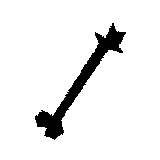
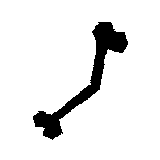
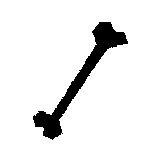
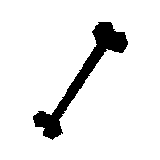
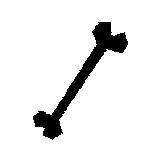
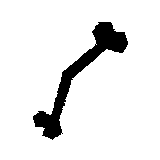
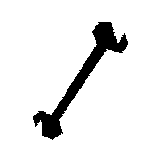
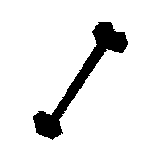
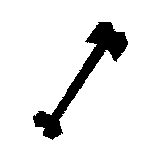
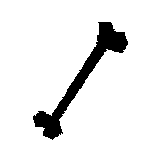
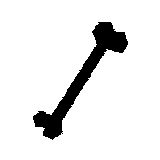
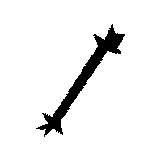
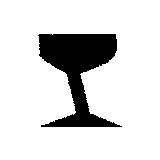
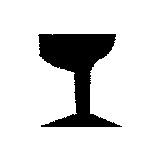
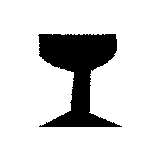
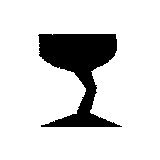
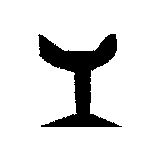
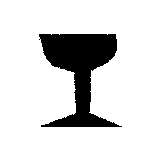
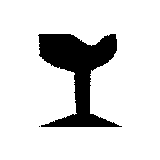
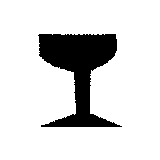
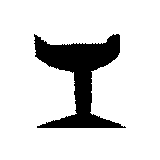
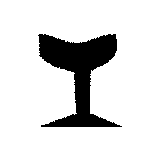
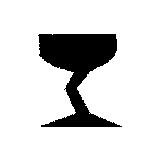
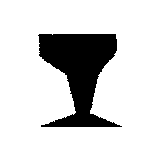
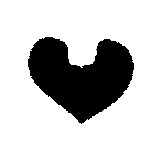
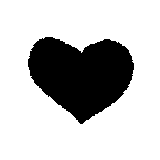
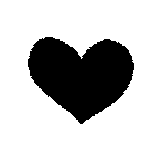
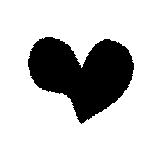
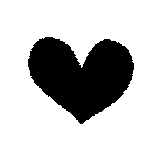
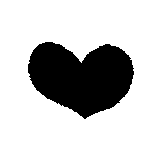
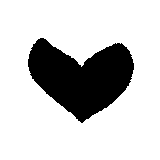
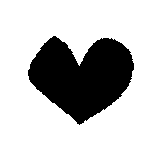
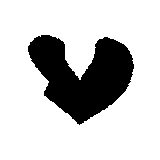
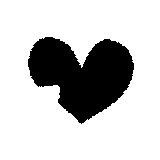
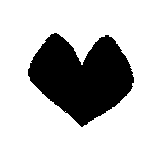
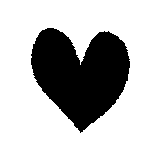
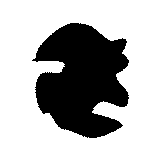
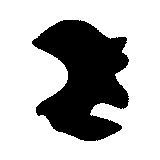
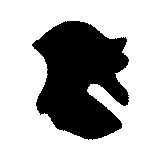
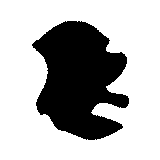
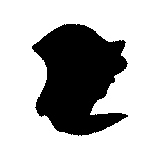
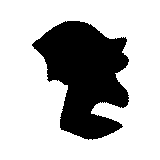
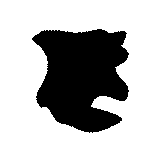
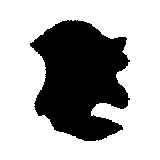
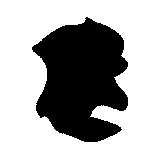
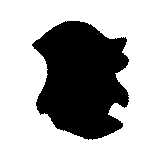
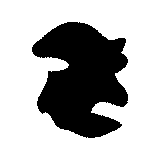
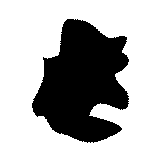
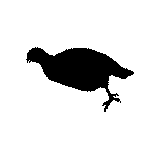
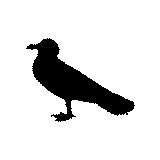
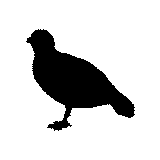
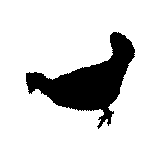
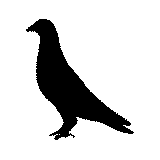
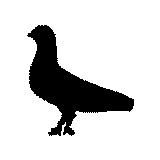
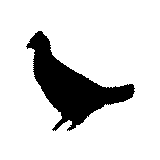
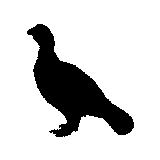
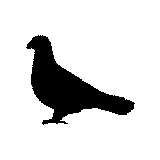
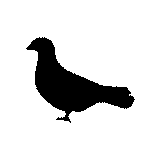
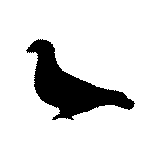
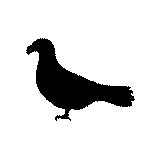
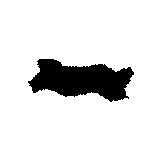
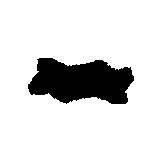
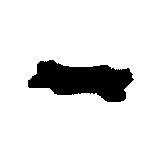
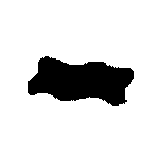
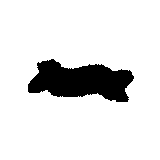
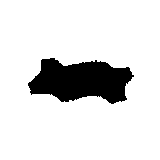
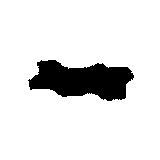
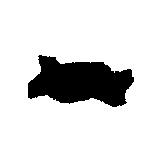
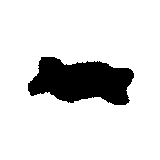
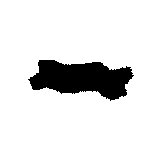
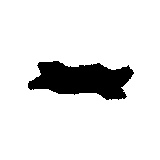
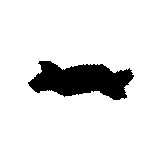
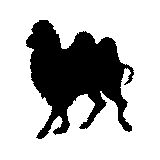
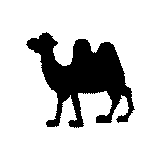
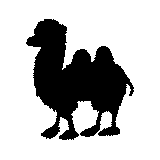
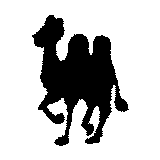
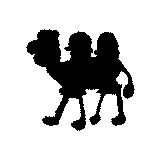
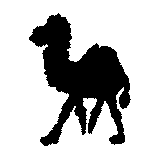
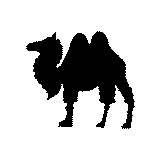
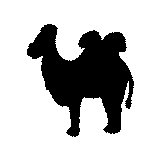
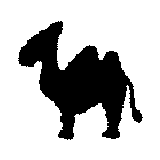
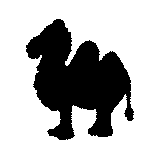
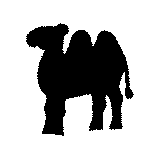
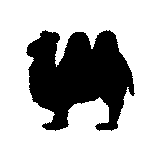
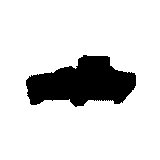
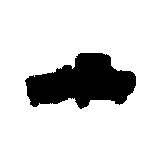
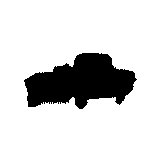
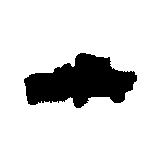
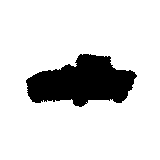
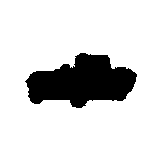
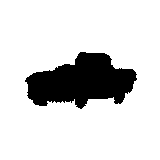
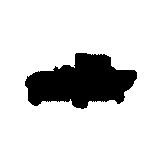
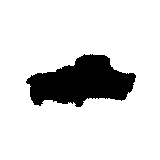
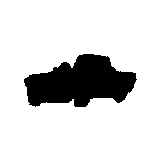
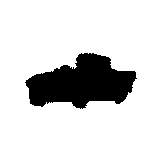
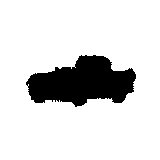
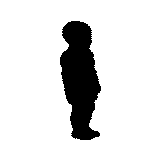
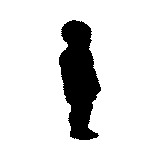
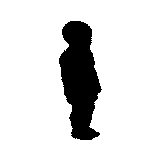
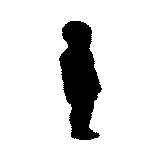
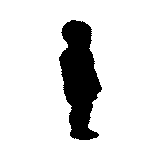
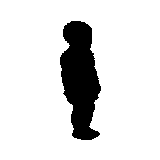
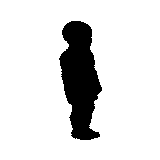
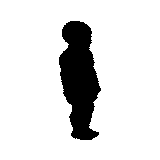
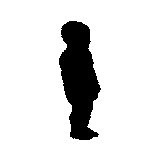
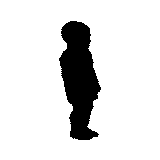
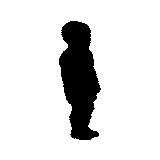
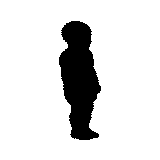
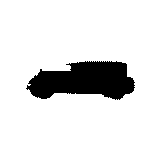
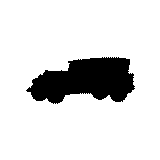
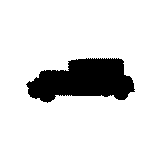
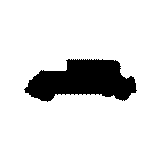
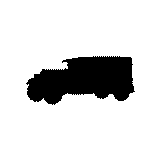
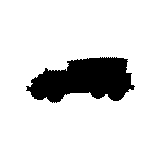
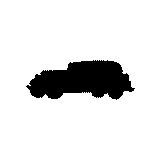
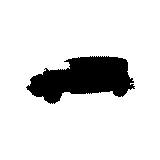
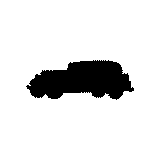
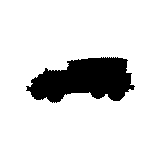
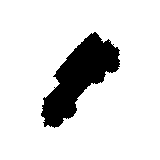
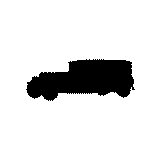
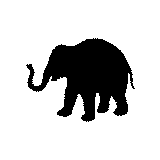
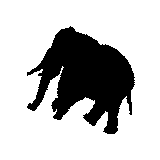
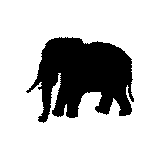
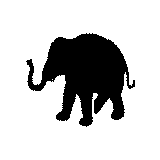
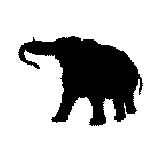
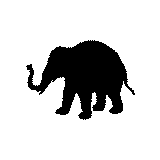
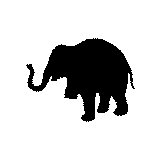
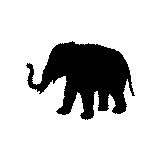
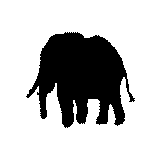
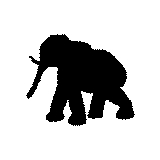
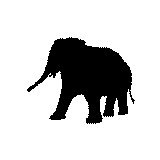
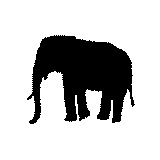
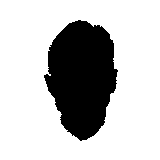
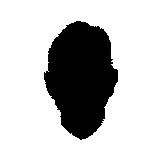
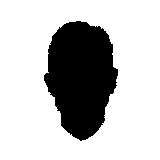
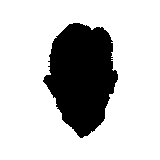
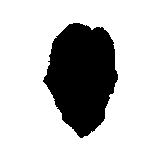
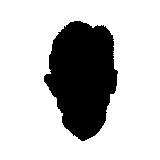
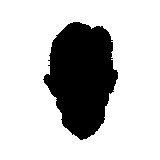
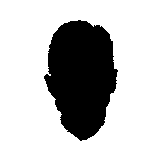
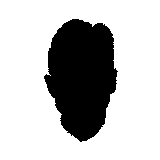
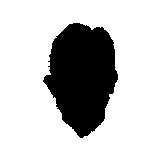
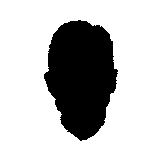
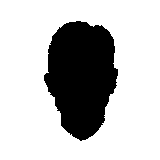
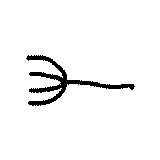
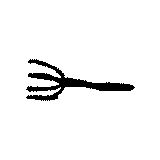
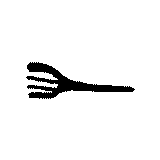
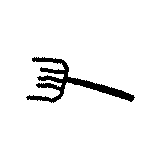
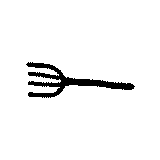
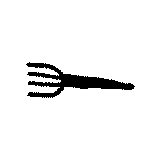
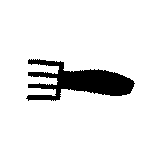
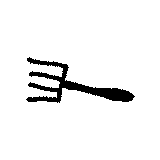
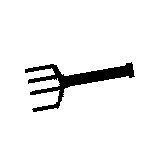
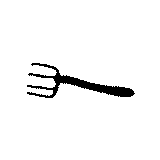
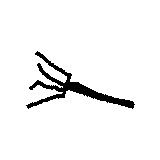
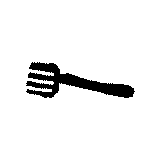
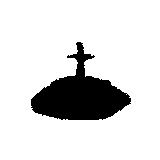
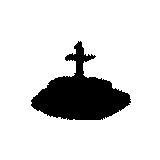
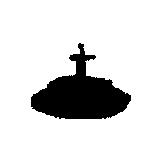
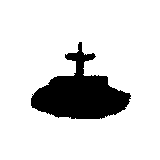
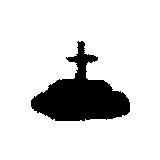
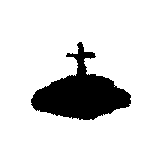
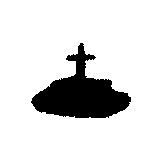
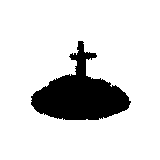
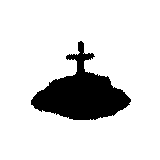
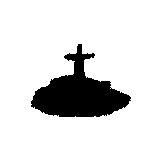
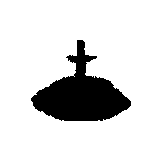
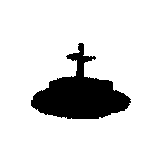
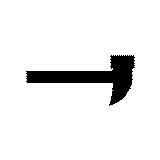
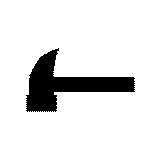
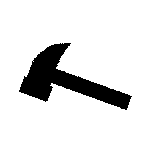
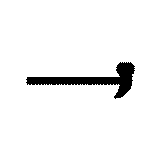
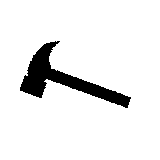
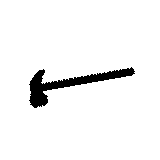
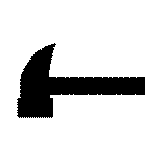
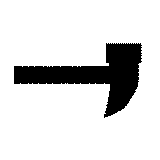
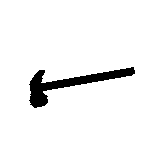
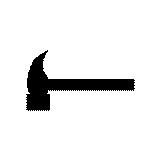
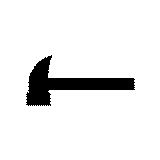
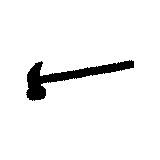
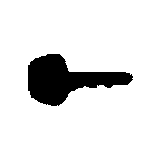
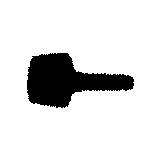
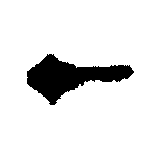
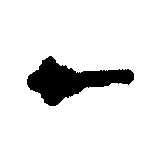
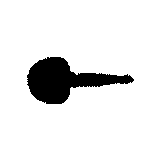
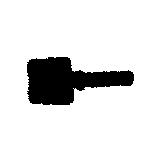
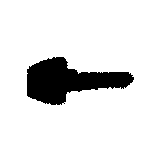
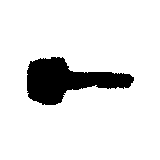
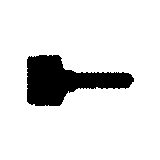
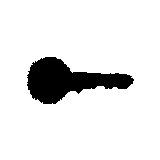
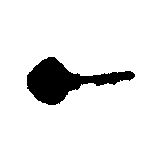
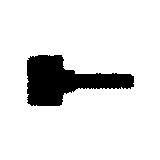
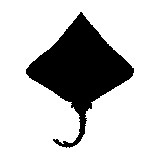
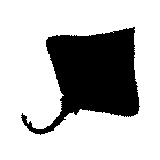
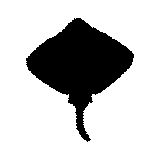
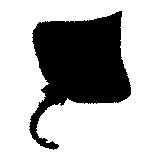
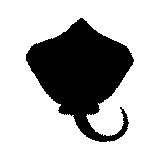
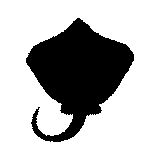
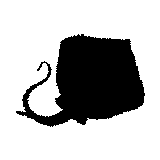
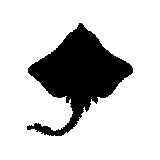
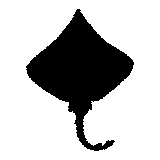
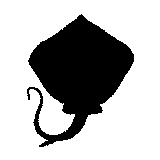
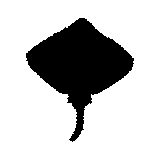
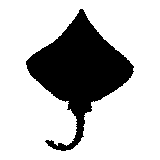
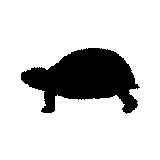
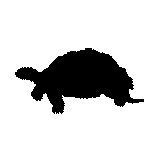
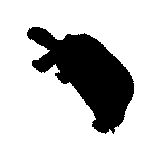
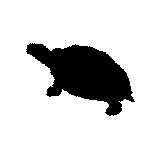
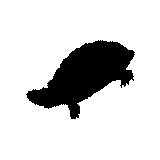
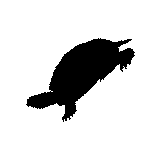
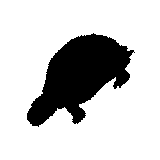
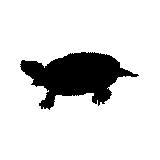
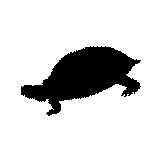
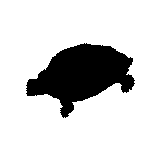
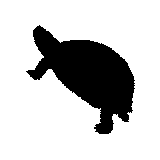
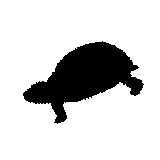


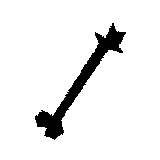
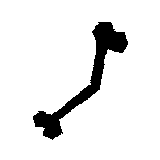
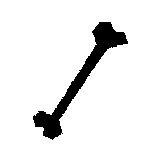
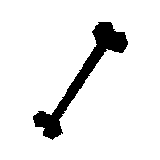
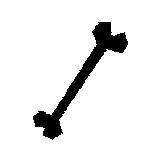
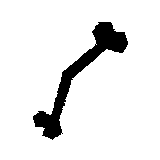
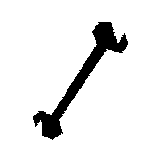
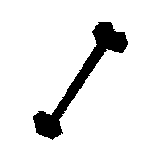
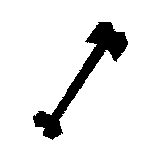
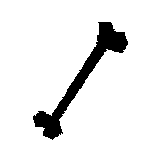
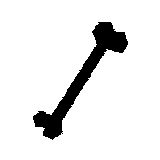
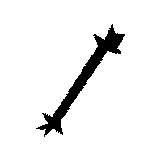
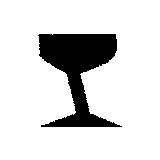
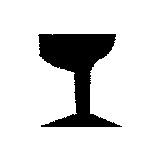
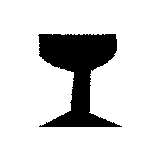
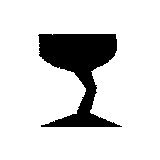
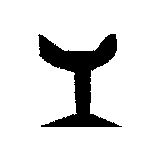
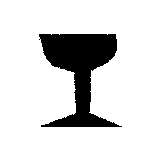
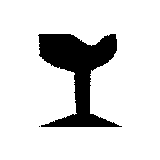
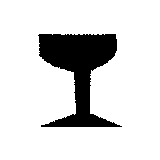
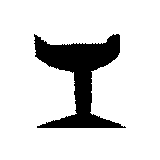
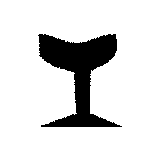
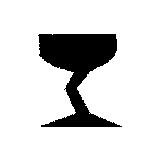
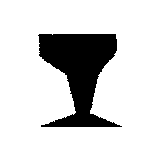
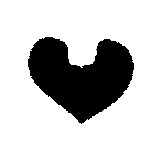
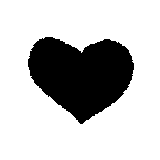
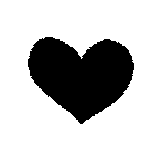
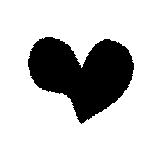
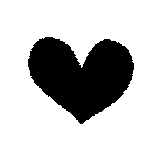
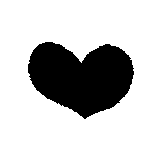
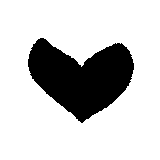
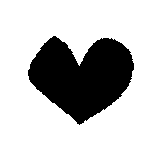
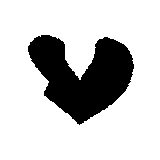
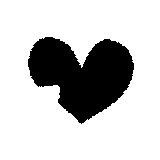
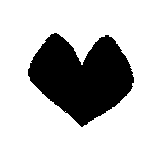
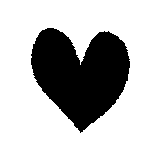
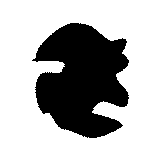
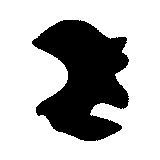
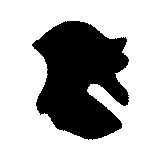
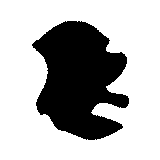
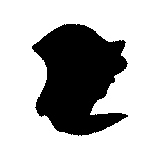
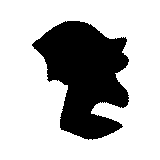
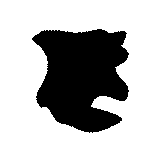
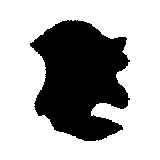
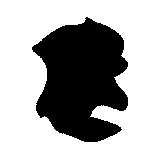
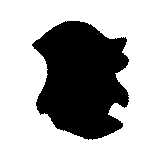
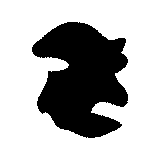
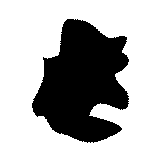
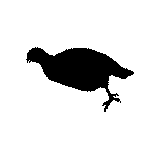
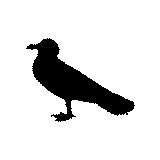
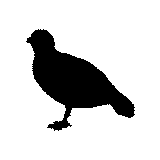
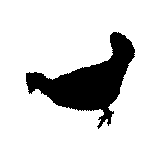
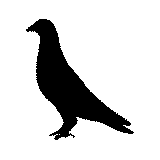
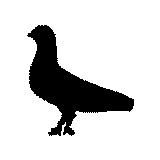
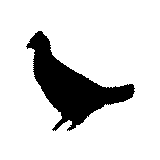
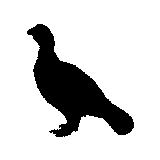
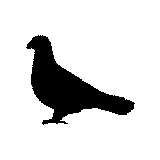
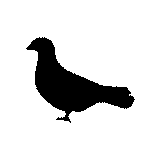
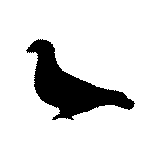
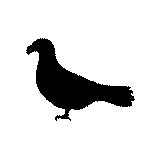
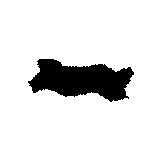
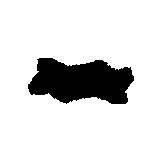
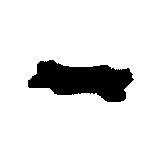
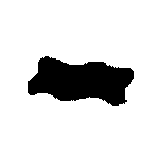
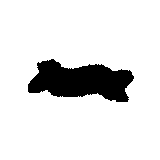
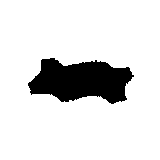
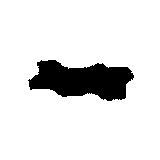
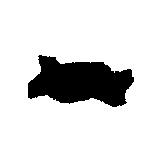
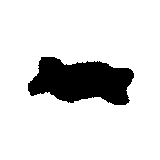
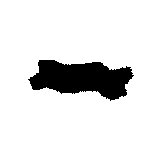
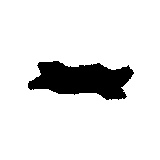
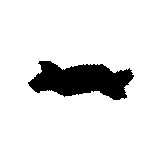
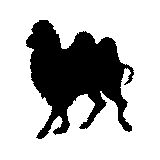
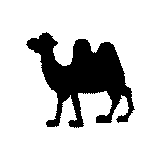
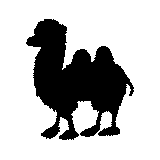
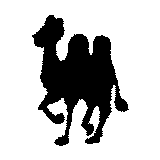
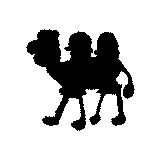
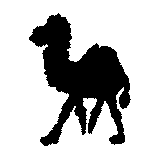
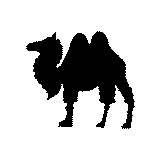
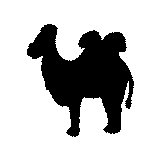
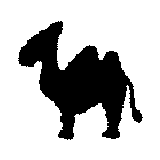
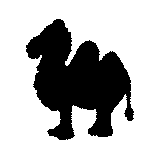
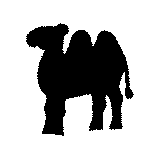
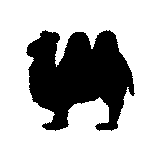
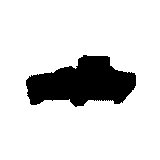
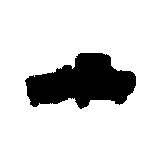
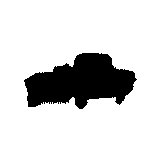
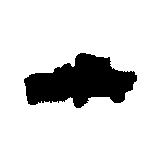
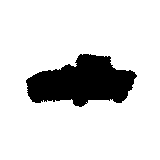
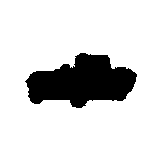
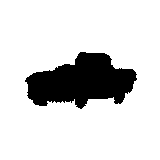
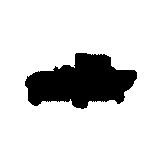
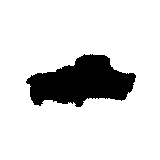
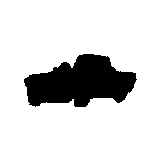
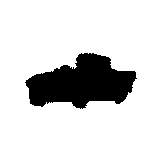
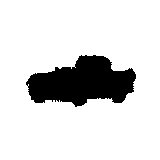
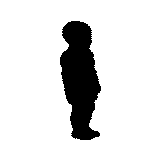
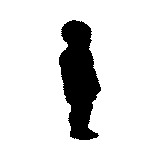
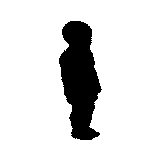
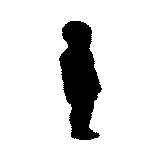
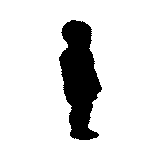
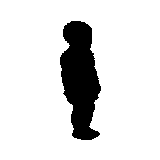
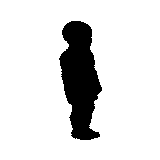
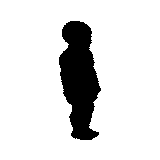
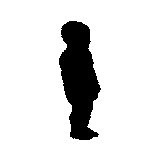
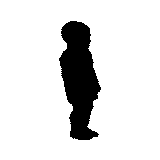
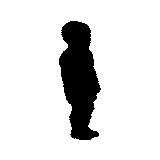
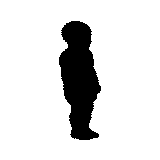
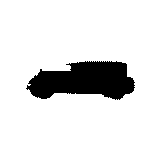
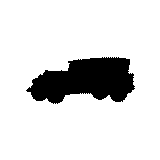
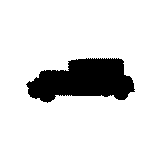
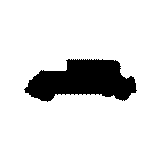
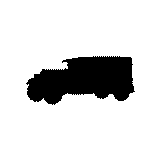
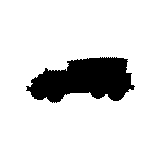
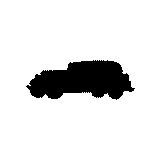
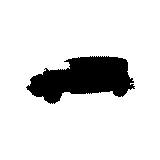
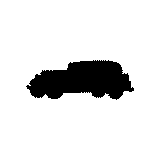
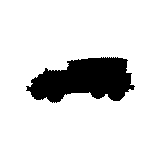
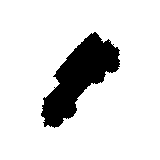
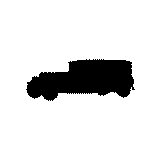
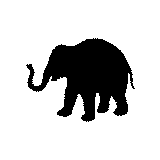
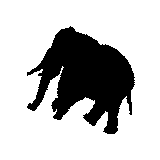
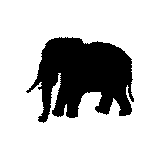
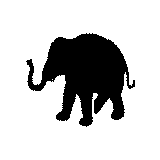
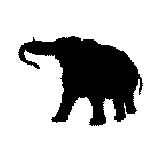
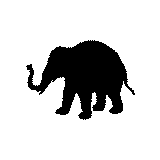
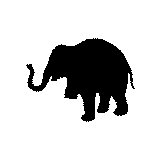
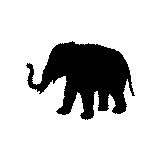
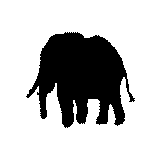
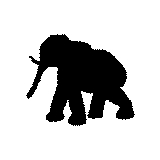
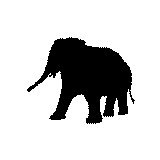
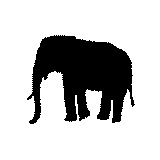
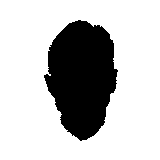
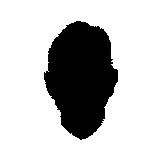
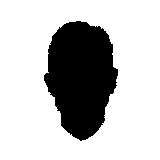
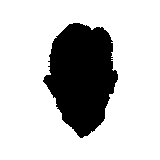
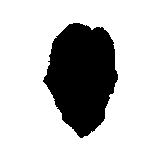
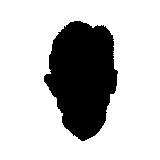
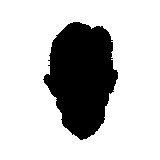
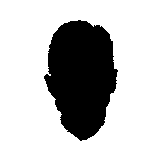
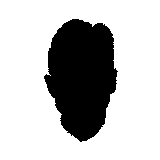
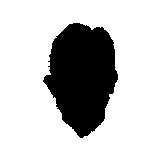
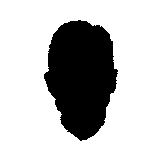
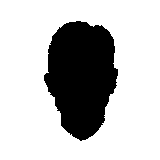
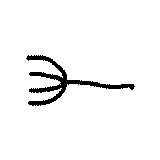
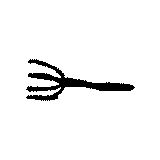
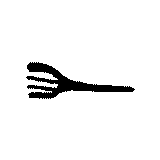
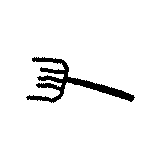
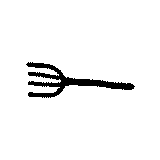
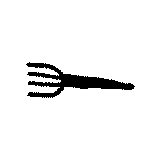
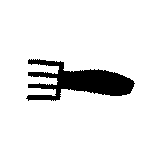
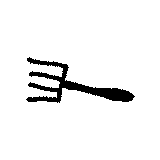
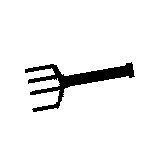
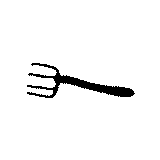
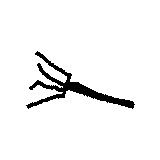
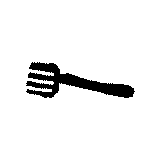
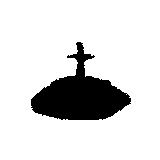
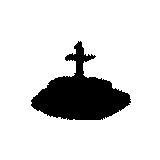
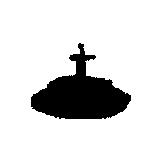
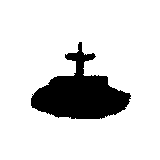
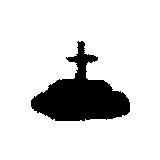
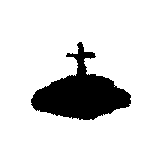
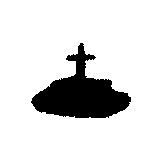
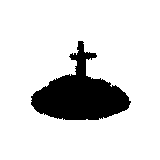
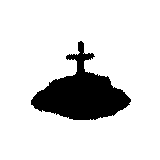
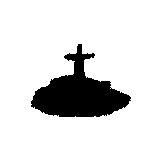
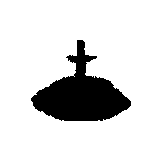
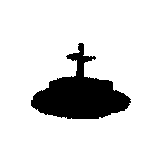
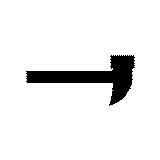
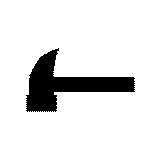
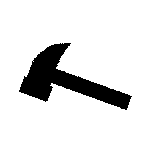
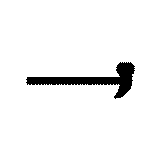
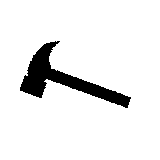
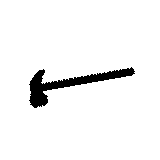
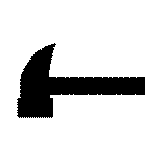
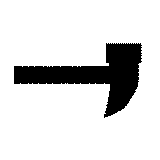
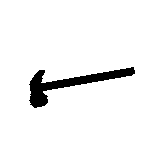
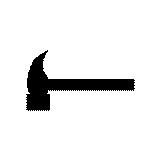
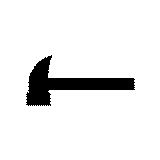
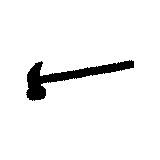
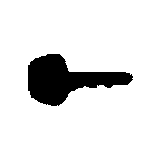
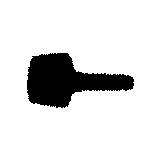
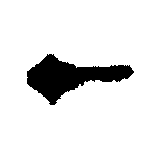
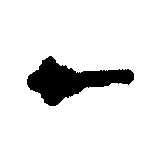
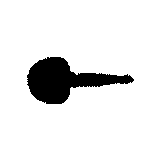
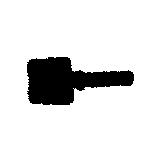
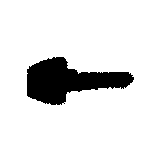
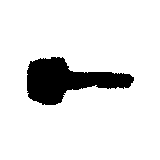
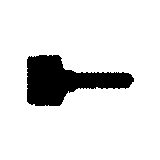
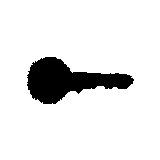
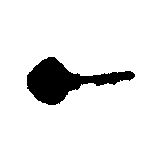
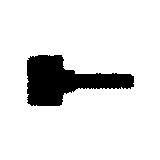
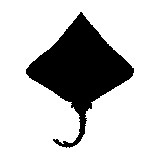
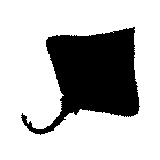
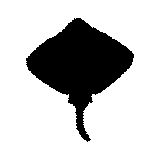
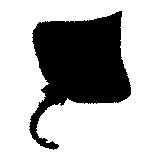
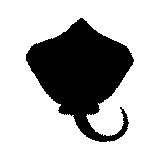
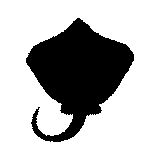
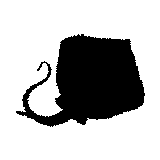
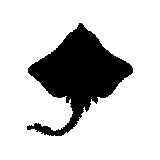
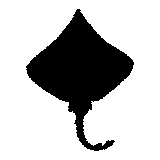
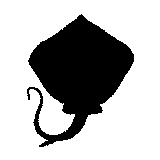
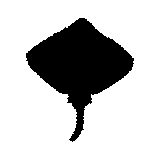
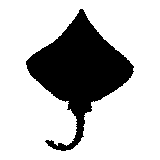
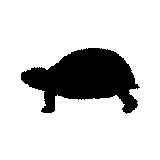
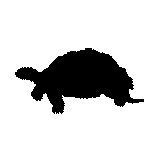
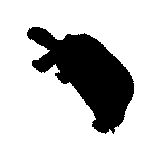
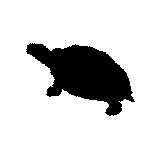
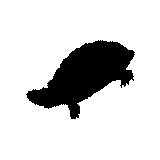
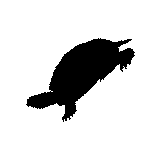
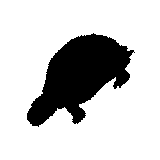
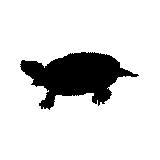
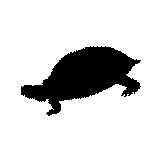
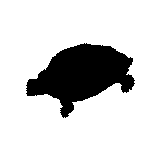
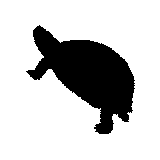
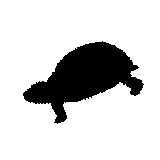

In [249]:
ipyplot.plot_class_tabs(images=[im["img"] for im in path_class_img], labels=[im["class"] for im in path_class_img], max_imgs_per_tab=20, img_width=100)

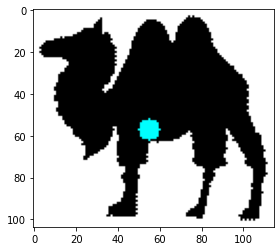

cx: 55, cy:57


In [283]:
# img moments
cv_img = cv.imread(path_class_img[:][120]["path"])

moments = cv.moments(cv_img[:,:,0])
cX = int(moments["m10"]/moments["m00"])
cY = int(moments["m01"]/moments["m00"])
cv.circle(cv_img, (cX, cY), 5, (0, 255, 255), -1)
plt.imshow(cv_img)
plt.show()

print(f'cx: {cX}, cy:{cY}')

## Passo 2?

In [2]:
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
import numpy as np

first = cv2.imread('./data/pngs/bird02.png')
second = cv2.imread('./data/pngs/bird04.png')

# Convert images to grayscale
first_gray = cv2.cvtColor(first, cv2.COLOR_BGR2GRAY)
second_gray = cv2.cvtColor(second, cv2.COLOR_BGR2GRAY)

# Compute SSIM between two images
score, diff = structural_similarity(first_gray, second_gray, full=True)
print("Similarity Score: {:.3f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type so we must convert the array 
# to 8-bit unsigned integers in the range [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")

# Threshold the difference image, followed by finding contours to
# obtain the regions that differ between the two images
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# Highlight differences
mask = np.zeros(first.shape, dtype='uint8')
filled = second.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 100:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(first, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(second, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.drawContours(mask, [c], 0, (0,255,0), -1)
        cv2.drawContours(filled, [c], 0, (0,255,0), -1)

cv2.imshow('first', first)
cv2.imshow('second', second)
cv2.imshow('diff', diff)
cv2.imshow('mask', mask)
cv2.imshow('filled', filled)
cv2.waitKey()

ValueError: Input images must have the same dimensions.

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

# Next we compute the embeddings
# To encode an image, you can use the following code:
# from PIL import Image
# encoded_image = model.encode(Image.open(filepath))
image_names = list(glob.glob('./data/pngs/*.png'))
print("Images:", len(image_names))
encoded_image = model.encode([Image.open(filepath).convert('RGB') for filepath in image_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

# Now we run the clustering algorithm. This function compares images aganist 
# all other images and returns a list with the pairs that have the highest 
# cosine similarity score
processed_images = util.paraphrase_mining_embeddings(encoded_image)
NUM_SIMILAR_IMAGES = 10 

# =================
# DUPLICATES
# =================
print('Finding duplicate images...')
# Filter list for duplicates. Results are triplets (score, image_id1, image_id2) and is scorted in decreasing order
# A duplicate image will have a score of 1.00
# It may be 0.9999 due to lossy image compression (.jpg)
duplicates = [image for image in processed_images if image[0] >= 0.999]

# Output the top X duplicate images
for score, image_id1, image_id2 in duplicates[0:NUM_SIMILAR_IMAGES]:
    print("\nScore: {:.3f}%".format(score * 100))
    print(image_names[image_id1])
    print(image_names[image_id2])

# =================
# NEAR DUPLICATES
# =================
print('Finding near duplicate images...')
# Use a threshold parameter to identify two images as similar. By setting the threshold lower, 
# you will get larger clusters which have less similar images in it. Threshold 0 - 1.00
# A threshold of 1.00 means the two images are exactly the same. Since we are finding near 
# duplicate images, we can set it at 0.99 or any number 0 < X < 1.00.
threshold = 0.99
near_duplicates = [image for image in processed_images if image[0] < threshold]

for score, image_id1, image_id2 in near_duplicates[0:NUM_SIMILAR_IMAGES]:
    print("\nScore: {:.3f}%".format(score * 100))
    print(image_names[image_id1])
    print(image_names[image_id2])

Loading CLIP Model...


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Images: 216


Batches: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it]

Finding duplicate images...

Score: 99.971%
./data/pngs\classic02.png
./data/pngs\classic03.png
Finding near duplicate images...

Score: 99.000%
./data/pngs\car04.png
./data/pngs\car12.png

Score: 98.999%
./data/pngs\car05.png
./data/pngs\key19.png

Score: 98.987%
./data/pngs\brick05.png
./data/pngs\brick14.png

Score: 98.986%
./data/pngs\children12.png
./data/pngs\children14.png

Score: 98.985%
./data/pngs\children11.png
./data/pngs\children19.png

Score: 98.976%
./data/pngs\hammer02.png
./data/pngs\hammer20.png

Score: 98.974%
./data/pngs\Bone04.png
./data/pngs\Bone09.png

Score: 98.971%
./data/pngs\face10.png
./data/pngs\face07.png

Score: 98.969%
./data/pngs\face02.png
./data/pngs\face04.png

Score: 98.968%
./data/pngs\children10.png
./data/pngs\children19.png


## parte 1 ...

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import cv2 as cv
import glob
import os

print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

image_names = list(glob.glob('./data/pngs/*.png'))
encoded_image = model.encode([Image.open(filepath).convert('RGB') for filepath in image_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

Loading CLIP Model...


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
Batches: 100%|██████████| 2/2 [00:14<00:00,  7.39s/it]


In [3]:
import ipyplot
search_image = Image.open('./data/pngs/bird04.png').convert('RGB')
encoded_search = model.encode(search_image, batch_size=128, convert_to_tensor=True, show_progress_bar=True)
similarity = []

for name, im in zip(image_names, encoded_image):
    similarity.append([name, util.cos_sim(encoded_search, im).numpy()[0][0]])
    
similarity.sort(key = lambda x: x[1], reverse=True)

ipyplot.plot_images([im[0] for im in similarity[:10]], ['Score: ' + str(im[1]) for im in similarity[:10]])

NameError: name 'Image' is not defined

[1, 2]